# 🏙️ Identifying Urban Features in Satellite Imagery using DINOv3-sat Embeddings
## 🧭 Objective

The goal of this notebook is to **cluster DINOv3-sat patch embeddings** extracted from a 2048 × 2048 RGB image
in order to **separate urban structures** — particularly **roads vs. rooftops** —
and to **visualize the clusters** as a color-coded (RGB) map aligned with the original image.

We will not train a classifier; instead, we’ll explore the feature space learned by the pretrained model
to understand whether unsupervised clusters correspond to meaningful physical objects.


## 🧪 Plan

1. **Load model and image**
3. **Cluster embeddings (unsupervised)**
4. **Visualize clusters**
5. **Interpret and refine**



In [7]:
from transformers import AutoImageProcessor, AutoModel
import torch

import matplotlib.pyplot as plt
import numpy as np
model_name = "facebook/dinov3-vitl16-pretrain-sat493m"  # smaller + sat-trained

processor = AutoImageProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).eval().to(device)

print("device:", device)


device: cuda


In [8]:
# import PIL to open the RGB image and torch to manage tensors and devices
from PIL import Image
import torch

# load your 2048×2048 RGB image from disk
IMG = Image.open("/home/mak/Downloads/Random1.png").convert("RGB")

# print size and mode to confirm it's RGB and large enough
print("Loaded image:", IMG.size, " mode:", IMG.mode)


Loaded image: (2190, 1125)  mode: RGB


In [9]:
# compute the next multiples of the ViT patch size (16) so patches tile cleanly without distortion
ps = 16
W, H = IMG.size
Wm, Hm = ((W + ps - 1) // ps) * ps, ((H + ps - 1) // ps) * ps

# print the current size and the nearest padded size (no resizing yet)
print(f"original: {W}x{H}  →  next multiples of {ps}: {Wm}x{Hm}  (add {Wm-W} px width, {Hm-H} px height)")


original: 2190x1125  →  next multiples of 16: 2192x1136  (add 2 px width, 11 px height)


In [10]:
# import torchvision transforms for tensor conversion and padding
from torchvision import transforms

# define a padding transform that adds 10 px to width and 9 px to height (right and bottom)
pad_to_multiple = transforms.Pad((0, 0, 10, 9), fill=0)

# apply padding + convert to tensor + normalize to [0,1] float32
to_tensor = transforms.Compose([pad_to_multiple, transforms.ToTensor()])

# run the transform and inspect new tensor shape (C,H,W)
img_tensor = to_tensor(IMG); print("tensor shape:", tuple(img_tensor.shape))

print(img_tensor.shape)  # should be (3, 2048, 2048)

tensor shape: (3, 1134, 2200)
torch.Size([3, 1134, 2200])


In [11]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-sat493m")
print(processor.image_mean, processor.image_std)


[0.43, 0.411, 0.296] [0.213, 0.156, 0.143]


In [12]:
# normalize using the exact mean/std values from the DINOv3-sat processor
normalize = transforms.Normalize(mean=processor.image_mean,
                                 std=processor.image_std)

# apply normalization, then add batch dimension and move to device
img_tensor = normalize(img_tensor)
x = img_tensor.unsqueeze(0).to(device)

# print confirmation to verify shape and device
print("ready tensor:", tuple(x.shape), " device:", x.device)


ready tensor: (1, 3, 1134, 2200)  device: cuda:0


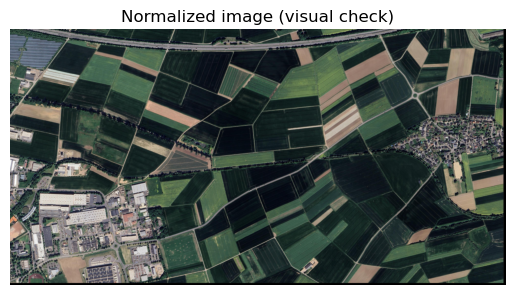

In [13]:
# reverse the normalization using the same mean/std to bring pixel values back to [0,1]
inv = transforms.Normalize(mean=[-m/s for m, s in zip(processor.image_mean,
                                                      [0.213, 0.156, 0.143])],
                           std=[1/s for s in [0.213, 0.156, 0.143]])

# apply the inverse transform and clamp to valid range
img_vis = torch.clamp(inv(img_tensor), 0, 1)

# plot the result as an RGB image (convert tensor to (H,W,C))
import matplotlib.pyplot as plt
plt.imshow(img_vis.permute(1, 2, 0))
plt.title("Normalized image (visual check)")
plt.axis("off"); plt.show()


In [14]:
# run a forward pass to get tokens without storing gradients (saves VRAM)
with torch.no_grad():
    out = model(pixel_values=x)

# drop the CLS and register tokens to keep only spatial (patch) tokens
R = getattr(model.config, "num_register_tokens", 0)
patch = out.last_hidden_state[:, 1 + R :, :]  # shape: (1, P, D)

# print the patch-token tensor shape to confirm counts (P tokens, D dims)
print("patch shape:", tuple(patch.shape))


patch shape: (1, 9590, 1024)


In [15]:
# compute the patch grid dimensions from your padded tensor size (H=1312, W=1904) and patch size 16
ps, H, W = 16, x.shape[2], x.shape[3]

# derive patches per side and confirm P = Hp*Wp matches 9758
Hp, Wp = H // ps, W // ps

# reshape flat tokens (1,P,D) → spatial grid (Hp,Wp,D) for mapping/clustering
patch_grid = patch.reshape(1, Hp, Wp, patch.shape[-1])

# print a sanity check of all shapes we’ll use next
print(f"HxW={H}x{W}  Hp×Wp={Hp}×{Wp}={Hp*Wp}  grid shape={tuple(patch_grid.shape)}")


HxW=1134x2200  Hp×Wp=70×137=9590  grid shape=(1, 70, 137, 1024)


In [16]:
# we’ll cluster in feature space, so build a 2D matrix X = (num_patches × feature_dim)
import numpy as np

# L2-normalize each patch vector so distance ~ cosine distance (helps k-means separate textures like roads/roofs)
X = patch[0].cpu().numpy().astype("float32")
X /= (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)

# print sanity checks before clustering
print("X shape:", X.shape, " mean L2 norm:", float(np.linalg.norm(X, axis=1).mean()))


X shape: (9590, 1024)  mean L2 norm: 1.0


In [17]:
# we’ll use MiniBatchKMeans to group similar patch embeddings (fast, memory-friendly) into k semantic clusters
from sklearn.cluster import MiniBatchKMeans

# choose an initial cluster count (k=8 is a reasonable start to separate roads/roofs/veg/shadows etc.)
kmeans = MiniBatchKMeans(n_clusters=8, random_state=12, batch_size=2048, max_iter=100)

# run clustering on the L2-normalized embeddings to obtain one label per patch (0..k-1)
labels = kmeans.fit_predict(X)

# report how many patches fell into each cluster so we can gauge balance before mapping to the image grid
print("labels shape:", labels.shape, " | counts per cluster:", np.bincount(labels, minlength=8))


labels shape: (9590,)  | counts per cluster: [1163 1082 1492 1394  956 1435  991 1077]


In [18]:
# reshape flat labels (P,) → spatial grid (Hp, Wp) so each patch label sits at its image position
label_grid = labels.reshape(Hp, Wp)

# quick sanity: report grid shape and how many distinct clusters are present
import numpy as np
print("label_grid:", label_grid.shape, " unique clusters:", np.unique(label_grid).size)

# we'll visualize this grid next with a discrete colormap (one color per cluster)


label_grid: (70, 137)  unique clusters: 8


visualizing clusters @ 70x137 with 8 clusters


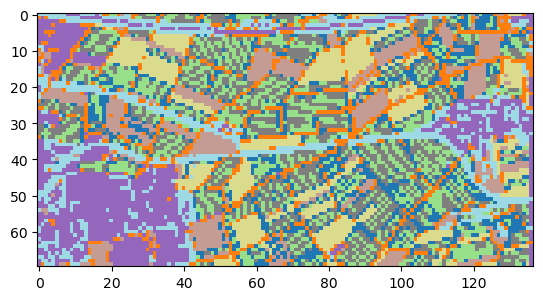

In [19]:
# import plotting; we'll use a discrete palette so clusters are clearly distinct
import matplotlib.pyplot as plt
# render the label grid with a categorical colormap and no smoothing between patches
plt.imshow(label_grid, cmap="tab20", interpolation="nearest")
# print a quick status so you know what you’re seeing (grid size and number of clusters)
print(f"visualizing clusters @ {label_grid.shape[0]}x{label_grid.shape[1]} with {label_grid.max()+1} clusters")
# display the figure
plt.show()
